<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Matias Armijo</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [2]:
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Carga de archivo de duracion 32 Segundos
ruta_archivo_comprimido = 'H-H1_GWOSC_16KHZ_R1-1126259447-32.txt.gz'
ruta_archivo_descomprimido = 'GW150914_H1_strain_32_sec.txt'

with gzip.open(ruta_archivo_comprimido, 'rb') as archivo_comprimido:
   with open(ruta_archivo_descomprimido,'wb') as archivo_descomprimido:
           shutil.copyfileobj(archivo_comprimido, archivo_descomprimido)


ruta_H1_32 = "GW150914_H1_strain_32_sec.txt"

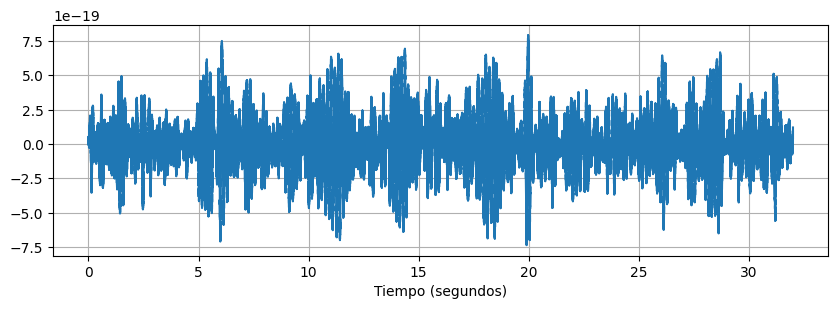

In [3]:
fs = 16384     # Tasa de muestreo según archivo .txt
duration = 32  # Duracion de la muestra
time = np.linspace(0,duration,duration*fs)

strain = np.loadtxt(ruta_H1_32, delimiter = ',', skiprows = 1, dtype=float)
normalized_strain = strain/max(strain)

# Grafico 
plt.figure(figsize=(10,3))
plt.plot(time,strain)
plt.xlabel("Tiempo (segundos)")
plt.grid()
plt.show()

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

8


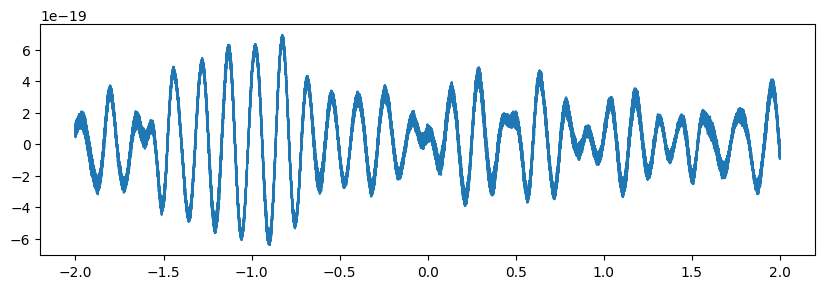

In [4]:
from IPython.display import Audio

# Segmentacion de la muestra de 32 segundos, en largos de 4 segundos con overlap
def slice(x,slice_length,overlap,spacing):
    num_samples = len(x)
    step = slice_length - overlap * 2  # Paso entre segmentos

    fragments = []
    start = 0
    while start < num_samples:
        end = min(start + slice_length, num_samples)
        fragment = x[start:end]
        fragments.append(fragment)
        start += step + spacing
    return fragments       

slice_length = 4*fs
slices = slice(strain,slice_length,overlap=slice_length//5,spacing=2*fs)
print(len(slices))

chunk = slices[3]

time_4s = np.linspace(-2,2,slice_length)

plt.figure(figsize=(10,3))
plt.plot(time_4s,chunk)

# Reproduccion del arreglo
Audio(chunk/max(chunk),rate=fs)

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


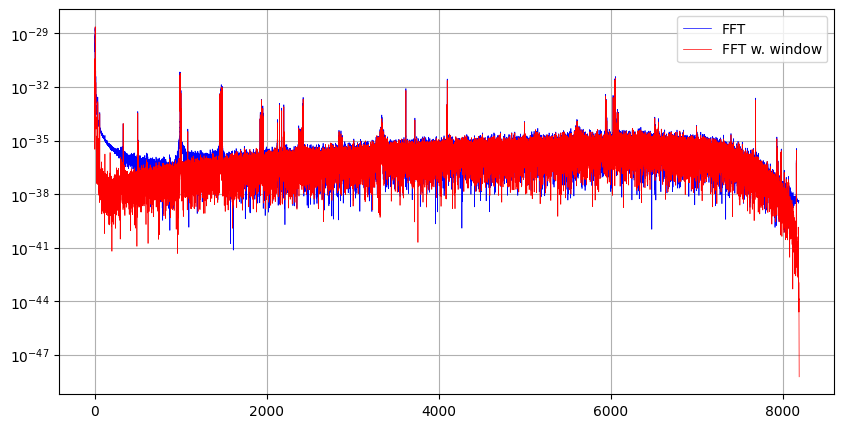

In [54]:
from scipy.fft import fft,ifft,fftfreq
from scipy.signal.windows import tukey

# FFT al trozo de señal "chunk"
chunk_fft = fft(chunk)
frecs = fftfreq(len(chunk),1/fs)

# Windowing
w = tukey(len(chunk),alpha=0.25)
chunk_fft_windowed = fft(chunk*w)

# Power Density
pdyf=np.abs(chunk_fft[1:len(chunk)//2])**2 #no windows
pdywf=np.abs(chunk_fft_windowed[1:len(chunk)//2])**2 #with window


#logarithmic scale plot
plt.figure(figsize=(10,5))
plt.semilogy(frecs[1:len(chunk)//2], pdyf, '-b',linewidth=.5)
plt.semilogy(frecs[1:len(chunk)//2],  pdywf, '-r',linewidth=.5)
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


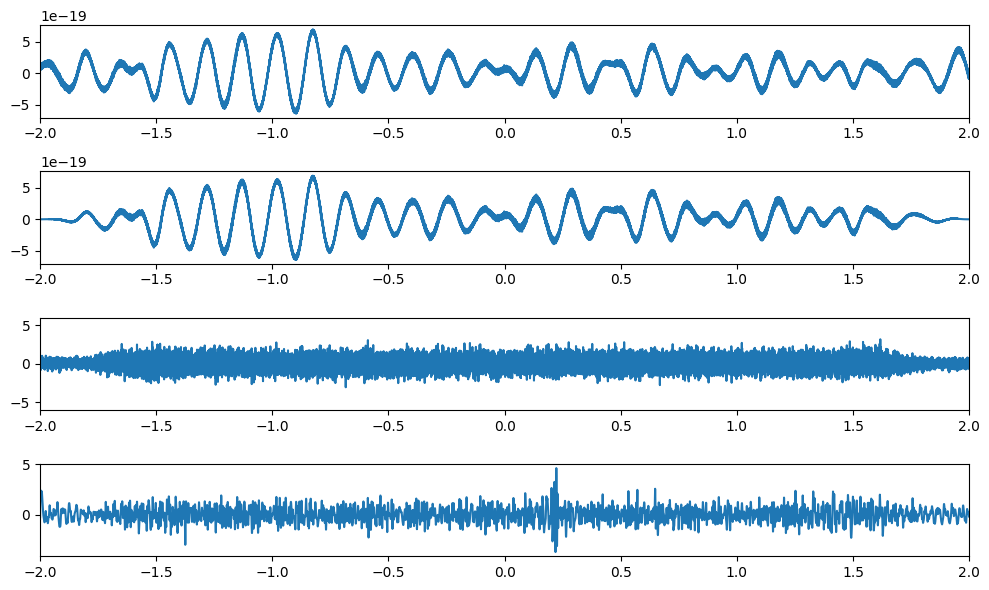

In [53]:
from scipy.signal import welch, butter, lfilter, sosfiltfilt

# Proceso de blanqueamiento de la señal
frequencies, psd = welch(strain,fs=fs,nperseg=slice_length,scaling='density',window='tukey',average='mean')
whitened_signal = ifft(chunk_fft_windowed[0:len(chunk_fft_windowed)//2+1]/np.sqrt(psd))
whitened_signal /= np.std(whitened_signal)



# Aplicar filtro pasa banda
def passband_filter(signal,order,lowcut,highcut,fs):
    # Normalizar las frecuencias de corte con respecto a la frecuencia de muestreo
    low = lowcut / (0.5 * fs)
    high = highcut / (0.5 * fs)
    # Diseñar el filtro Butterworth pasa banda
    sos = butter(order, [low, high], btype='band',output='sos')
    # Aplicar el filtro a la señal
    filtered_signal = sosfiltfilt(sos, signal)
    return filtered_signal


filtered_signal = passband_filter(whitened_signal,8,35,450,fs)
filtered_signal /= np.std(filtered_signal)



time2 = np.linspace(-2,2,len(filtered_signal))


plt.figure(figsize=(10,6))
plt.subplot(4,1,1)
plt.plot(time_4s,chunk)
plt.xlim(min(time_4s),max(time_4s))
plt.subplot(4,1,2)
plt.plot(time_4s,chunk*w)
plt.xlim(min(time_4s),max(time_4s))
plt.subplot(4,1,3)
plt.plot(time2,whitened_signal)
plt.xlim(min(time_4s),max(time_4s))
plt.ylim(-6,6)
plt.subplot(4,1,4)
plt.xlim(min(time_4s),max(time_4s))
plt.plot(time2,filtered_signal)

plt.tight_layout()
plt.show()



# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

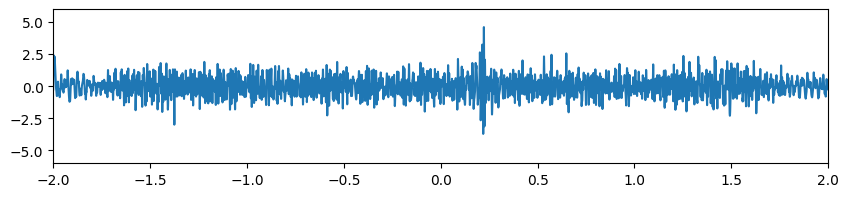

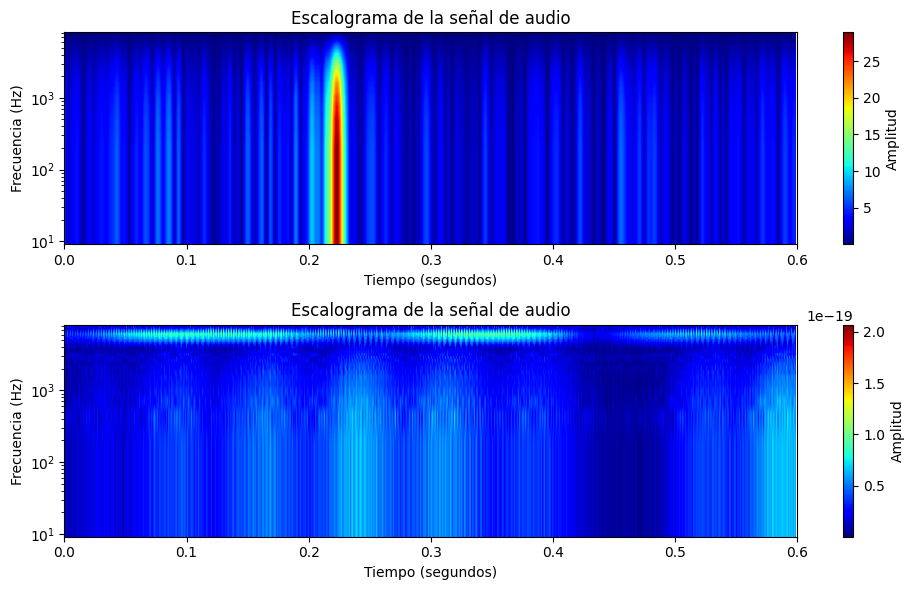

In [107]:
from scipy import signal
import pywt


resampled_signal = signal.resample(filtered_signal,4*fs)

plt.figure(figsize=(10,2))
plt.plot(time_4s,resampled_signal)
plt.xlim(min(time_4s),max(time_4s))
plt.ylim(-6,6)

# Calcula la transformada wavelet usando la función "cwt" de pywavelets
widths = np.arange(1, 31)  # Anchuras de las wavelets
cwtmatr, freqs = pywt.cwt(resampled_signal,widths, 'fbsp')  # 'mexh' es la familia de wavelets


# Convierte las muestras de tiempo a segundos
# Convierte las frecuencias centrales de las wavelets a frecuencias en Hertz
# Utiliza la fórmula: frecuencia_en_hz = frecuencia_central * (frecuencia_de_muestreo / ancho_de_wavelet)
freqs_hz = freqs * (fs / widths)

# Plot
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.imshow(np.abs(cwtmatr), extent=[time_4s[0], time_4s[-1], freqs_hz[-1], freqs_hz[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Amplitud')
plt.xlabel('Tiempo (segundos)')
plt.xlim(0,0.6)
plt.ylabel('Frecuencia (Hz)')
plt.yscale('log')
plt.title('Escalograma de la señal de audio')

cwtmatr_2, freqs = pywt.cwt(chunk,widths, 'fbsp')  # 'mexh' es la familia de wavelets

plt.subplot(2,1,2)
plt.imshow(np.abs(cwtmatr_2), extent=[time_4s[0], time_4s[-1], freqs_hz[-1], freqs_hz[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Amplitud')
plt.xlabel('Tiempo (segundos)')
plt.xlim(0,0.6)
plt.ylabel('Frecuencia (Hz)')
plt.yscale('log')
plt.title('Escalograma de la señal de audio')

plt.tight_layout()
plt.show()

Audio(resampled_signal/max(resampled_signal),rate=fs)